# Bus link travel time correlation estimation using synthesis data

In [175]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from numpy.linalg import inv as inv
from numpy.linalg import solve
from scipy.stats import invwishart
import scipy.io
import time
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import gaussian_kde

In [369]:
def Corr(cov):
    
    '''
    Covariance to Correlation
    
    '''
    p = len(cov)
    e = np.eye(p)
    variance = e*cov
    v = np.power(variance,0.5)
    I = np.linalg.inv(v)
    corr = I.dot(cov).dot(I)
    return corr

def imputation(mu, Sigma, G, r):
    
    '''
    refer the algorithm proposed in
    Cong, Y., Chen, B., & Zhou, M. (2017). Fast simulation of hyperplane-truncated multivariate normal distributions. 
    Bayesian Analysis, 12(4), 1017-1037.
    
    '''
    y = mvnrnd(mu, Sigma).reshape(-1, 1)
    alpha = solve(G @ Sigma @ G.T, r.reshape(-1,1) - G @ y)
    x = (y + Sigma @ G.T @ alpha).T
    return x

def Bayesian_Test(test_data):
    
    '''
    Equivalence test based on credible interval and region of practical equivalence (ROPE)
    - Credible Interval: 95%
    - ROPE: [-0.05,0.05]
    - reject/accpet threshold 2.5%
    
    '''
    iteration, d1, d2 = test_data.shape
    Sig = np.zeros((iteration, d1, d2))
    for it1 in range(iteration):
        Sig[it1, :, :] = Corr(test_data[it1, :, :])
    C = Sig.mean(axis = 0)
    for id1 in range(d1):
        for id2 in range(d2):
            db = Sig[:,id1,id2]
            lower = np.percentile(db, 0)   # credible interval
            upper = np.percentile(db, 100)
            CI_num = len(db[(db > lower) & (db < upper)])
            CI_value = db[(db > lower) & (db < upper)]
            PORE_num = len(CI_value[(CI_value > -0.05) & (CI_value < 0.05)])
            thres = PORE_num / CI_num
            if thres > 5/100:
                C[id1, id2] = 0
    return C

def kl_divergence(mu1, mu2, sigma_1, sigma_2):

    '''
    
    KL-divergence
    
    '''
    
    sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
    sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2
    sigma_diag_2_inv = np.linalg.inv(sigma_diag_2)
    kl = 0.5 * (np.log(np.linalg.det(sigma_diag_2) / np.linalg.det(sigma_diag_1)) 
                - mu1.shape[0] + np.trace(sigma_diag_2_inv @ sigma_diag_1)
                + (mu2 - mu1).T @ sigma_diag_2_inv @ (mu2 - mu1))
    return kl


def CI(test_data, id1, id2):
    
    '''
    Credible Interval
    
    '''
    iteration, d1, d2 = test_data.shape
    Sig = np.zeros((iteration, d1, d2))
    for it1 in range(iteration):
        Sig[it1, :, :] = Corr(test_data[it1, :, :])
    C = Sig.mean(axis = 0)
    db = Sig[:,id1,id2]
    lower = np.percentile(db, 2.5)
    upper = np.percentile(db, 97.5)
    return np.around(lower, 2), np.around(upper, 2)

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

### Generate simulation data

In [350]:
# Construct matrix G (linear constrains)

link_num = 18
A1 = np.zeros((18,link_num))
A1[:,:]=np.eye(18)

A2 = np.zeros((17,link_num))
A2[:4,:4] = np.eye(4)
A2[5:,6:] = np.eye(12)
A2[4,4:6] = 1

A3 = np.zeros((12,link_num))
A3[:,:12] = np.eye(12)

A4 = np.zeros((14,link_num))
A4[:,4:] = np.eye(14)

# mean = np.array([14,15,18,13,17,15,10,24,15,11,12,15,9,13,17,15,19,21])
# cov = scipy.io.loadmat(r'C:\Data\cov.mat')
# cov = 10 * cov['cov']

#  We have generated simulation data
r = np.load(r'G:\\Test\\new\\data_simulation.npz') 
mean = r["mean"]
cov = r["cov"]
b1 = r["b_1"]
b2 = r["b_2"]
b3 = r["b_3"]
b4 = r["b_4"]

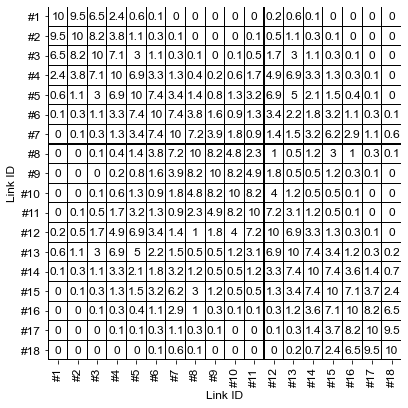

In [354]:
import matplotlib.pyplot as plt
import seaborn as sns


f,ax = plt.subplots(figsize=(6.5,6.5))
plt.rc('font',family='Arial',size=12)
sns.despine(bottom=False, right=False)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
sns.heatmap(np.around(cov,1),linewidths = 0.05,linecolor='black', annot=True,square=True,cbar=0,
                 annot_kws={'size':12, 'color':'black'},vmin=0,vmax=10000,cmap="Greys",
                xticklabels=x_tick, yticklabels=y_tick)

plt.xlabel('Link ID') 
plt.ylabel('Link ID')

# plt.xticks(fontsize=20) 
# plt.yticks(fontsize=20) 
# ax.set_title('True covariance matrix 1',fontdict= {'fontsize': 25})
# ax.tick_params(axis='x',labelsize=20)
# plt.savefig(r'C:\Data\Synthesis_Estimation.png')
plt.savefig('G:\\Test\\New\\cov1.pdf', bbox_inches='tight')

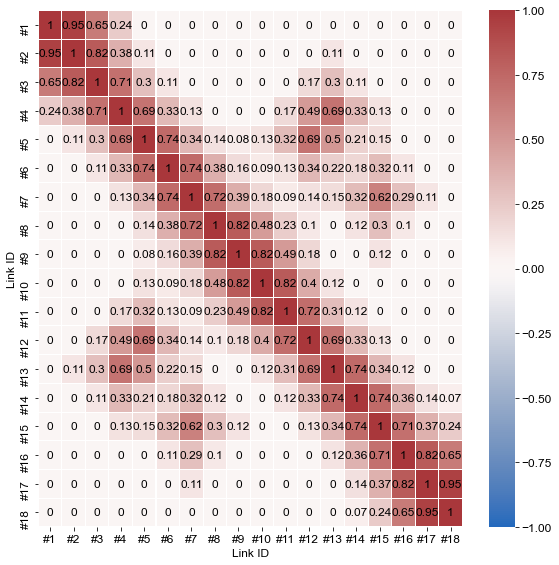

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_plot = Corr(cov)
corr_plot[corr_plot < 0.06] = 0
plt.subplots(figsize=(9.5, 9.5))
plt.rc('font',family='Arial',size=12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
ax = sns.heatmap(np.around(corr_plot,2),linewidths = 0.005, annot=True,
                 annot_kws={'size':12, 'color':'black'},vmin=-1,vmax=1,cmap="vlag",xticklabels=x_tick, yticklabels=y_tick)
# ax.set_title('True correlation matrix',fontdict= {'fontsize': 25})
ax.tick_params(axis='x',labelsize=12)
plt.xlabel('Link ID') 
plt.ylabel('Link ID')
plt.savefig(r'G:\\Test\\new\\True.pdf', bbox_inches = 'tight')

In [356]:
# Covariance

start = time.time()
maxepoch = 15000
mu_store1 = np.zeros((maxepoch, link_num))
Sigma_store1 = np.zeros((maxepoch, link_num, link_num))

# initialize the parameters of priors
flag = 0
beta_0 = 10
v_0 = link_num + 2
W_0 = np.eye(link_num) # 20*20
mu_0 = b1.mean(axis = 0)

X = b1
N = X.shape[0]
X_bar = np.mean(X, axis = 0)
mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
S = (N - 1) * np.cov((X - bar_d).T)
W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)  
Sigma_hyper = np.eye(link_num)
X_1 = b1

for epoch in range(maxepoch):
    X = X_1
    N = X.shape[0]
    X_bar = np.mean(X, axis = 0)
    mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
    bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
    S = (N - 1) * np.cov((X - bar_d).T)
    W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)
    Sigma_hyper = invwishart.rvs(df = N + v_0, scale = W_hyper)

    # store the mu and Lambda
    mu_store1[epoch, :] = mu_hyper
    Sigma_store1[epoch, :, :] = Sigma_hyper
    if epoch % 1000 == 0:
        flag += 1
        print(flag)
end = time.time()
print('Running time: %d seconds' % (end - start))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Running time: 4 seconds


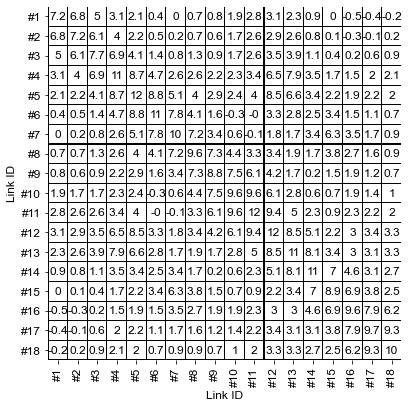

In [409]:
import matplotlib.pyplot as plt
import seaborn as sns

f,ax = plt.subplots(figsize = (6.5, 6.5))
plt.rc('font', family = 'Arial', size = 12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
sns.despine(bottom = False, right = False)
sns.heatmap(np.around(Sigma_store1[10000:, :, :].mean(axis = 0), 1), linewidths = 0.05, linecolor = 'black', annot = True, square = True, cbar = 0,
                 annot_kws = {'size':12, 'color':'black'}, vmin = 0, vmax = 10000, cmap = "Greys",
                xticklabels = x_tick, yticklabels = y_tick)

plt.xlabel('Link ID') 
plt.ylabel('Link ID')

plt.savefig('G:\\Test\\new\\est_cov1.pdf', bbox_inches = 'tight')

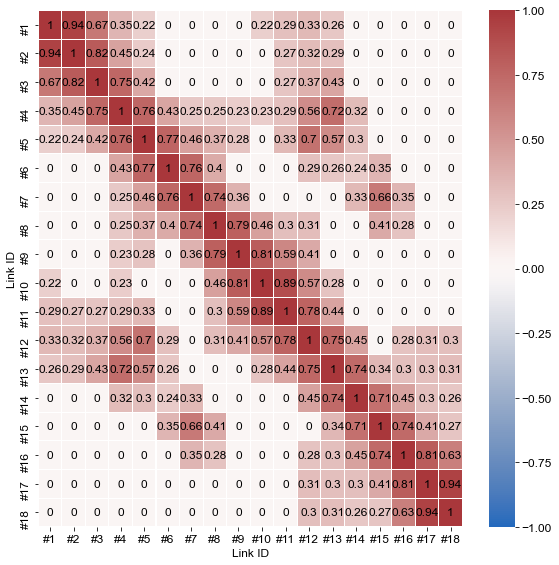

In [370]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_plot = Bayesian_Test(Sigma_store1[-5000:, :, :])
plt.subplots(figsize=(9.5, 9.5))
plt.rc('font',family='Arial',size=12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
ax = sns.heatmap(np.around(corr_plot,2),linewidths = 0.005, annot=True,
                 annot_kws={'size':12, 'color':'black'},vmin=-1,vmax=1,cmap="vlag",xticklabels=x_tick, yticklabels=y_tick)
# ax.set_title('True correlation matrix',fontdict= {'fontsize': 25})
ax.tick_params(axis='x',labelsize=12)
plt.xlabel('Link ID') 
plt.ylabel('Link ID')
# plt.savefig(r'C:\Data\Synthesis_Estimation.png')
plt.savefig('G:\\Test\\new\\Estimated_Completedata.pdf', bbox_inches='tight')

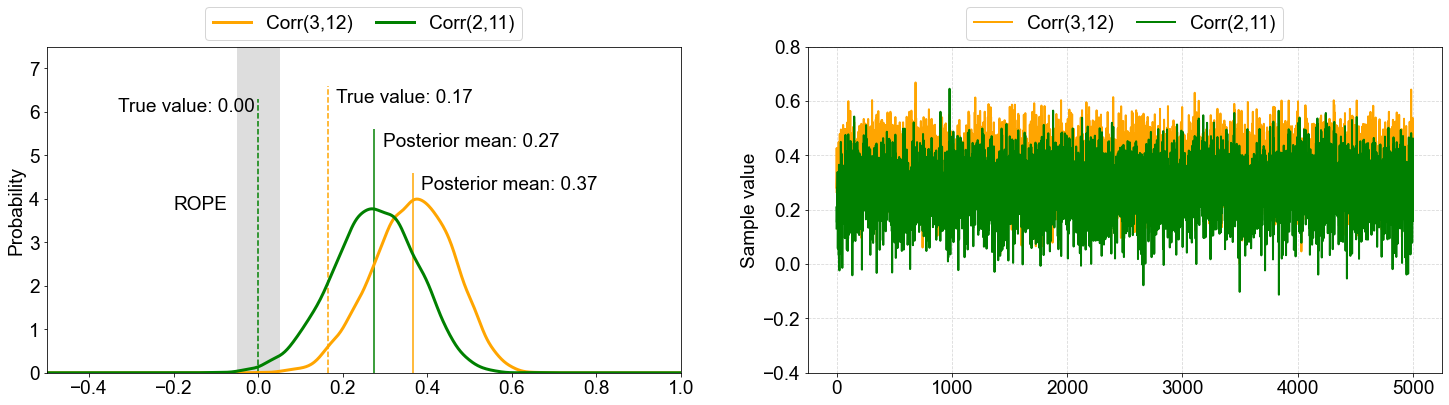

In [419]:
fig, ax = plt.subplots(1, 2, figsize = (25, 6)) # a figure with a 2x2 grid of Axes
x_time = np.arange(0, 5000)
fontset = {'fontsize': 19, 'color': 'black'}
plt.rc('font',family='Arial',size=19)

Sig_1 = Sigma_store1[10000:,:,:]
iteration, d1, d2 = Sig_1.shape
A1_store = np.zeros((iteration, d1, d2))
for it1 in range(iteration):
    A1_store[it1, :, :,] = Corr(Sig_1[it1, :, :])
cd = A1_store
corr_true = Corr(cov)
c11 = 2
c12 = 11
c21 = 1
c22 = 10
data = cd[:, c11, c12]
density = gaussian_kde(data)
xs = np.linspace(-2, 2, 2000)
data2 = cd[:, c21, c22]
density2 = gaussian_kde(data2)

ax[0].plot(xs, density(xs), color = 'orange', linestyle = '-', linewidth = 3, label = 'Corr(3,12)')
ax[0].plot(xs, density2(xs), color = 'green', linestyle = '-', linewidth = 3, label = 'Corr(2,11)')
# ax[0].set_title('cov(4,11)',fontdict = fontset)
ax[0].legend()
# ax[0].set_xlabel('',fontdict = fontset)
ax[0].vlines(data.mean(axis = 0), 0, 4.6, colors = "orange", linestyles = "-")
ax[0].text(data.mean(axis = 0) + 0.02, 4.2, 'Posterior mean: ' + str(np.around(data.mean(axis = 0), 2)))
ax[0].vlines(corr_true[c11, c12], 0, 6.6, colors = "orange", linestyles = "--")
ax[0].text(corr_true[c11, c12] + 0.02, 6.2, 'True value: ' + str(np.around(corr_true[c11, c12], 2)))
ax[0].vlines(data2.mean(axis = 0), 0, 5.6, colors = "green", linestyles = "-")
ax[0].text(data2.mean(axis = 0) + 0.02, 5.2, 'Posterior mean: ' + str(np.around(data2.mean(axis = 0), 2)))
ax[0].vlines(0, 0, 6.3, colors = "green", linestyles = "--")
ax[0].text(- corr_true[c21, c22] - 0.32, 6.0, 'True value: 0.00')
ax[0].fill_between([-0.05, 0.05], [7.5, 7.5], [0, 0], color = "#dddddd")
ax[0].text(- 0.2, 3.75, 'ROPE')
ax[0].set_xlim(-0.5, 1)
ax[0].set_ylim(0, 7.5)
ax[0].set_ylabel('Probability',fontdict = fontset)
ax[0].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

ax[1].plot(x_time, data, color = 'orange', linestyle = '-', linewidth = 2, label = 'Corr(3,12)')
ax[1].plot(x_time, data2, color = 'green', linestyle = '-', linewidth = 2, label = 'Corr(2,11)')
# ax[1].set_title('cov(4,11)',fontdict = fontset)
# ax[1].set_xlabel('',fontdict = fontset)
ax[1].set_ylim(-0.4, 0.8)
ax[1].set_ylabel('Sample value',fontdict = fontset)
ax[1].grid(linestyle = '--', color = '0.85', visible = True)
ax[1].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
fig.savefig('G:\\Test\\new\\markov_sampling1.pdf', bbox_inches='tight')

In [359]:
# Covariance
# initialization

start = time.time()

# gibbs sampling

maxepoch = 15000
mu_store2 = np.zeros((maxepoch, link_num))
Sigma_store2 = np.zeros((maxepoch, link_num, link_num))

# initialize the parameters of priors

flag = 0
beta_0 = 10
v_0 = link_num + 2
W_0 = np.eye(link_num) # 20*20
mu_0 = b1.mean(axis = 0)

X = b1
N = X.shape[0]
X_bar = np.mean(X, axis = 0)
mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
S = (N - 1) * np.cov((X - bar_d).T)
W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)  
Sigma_hyper = W_hyper / (N + v_0 - link_num - 1)

X_1 = b1
X_3 = np.zeros((b3.shape[0],link_num))
X_4 = np.zeros((b4.shape[0],link_num))

for epoch in range(maxepoch):

    # Route 2 
    for i in range(X_3.shape[0]):
        X_3[i] = imputation(mu_hyper,Sigma_hyper,A3,b3[i])

    # Route 3
    for i in range(X_4.shape[0]):
        X_4[i] = imputation(mu_hyper,Sigma_hyper,A4,b4[i])

    X = np.vstack((X_1, X_3, X_4))
    N = X.shape[0]
    X_bar = np.mean(X, axis = 0)
    mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
    bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
    S = (N - 1) * np.cov((X - bar_d).T)
    W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)
    Sigma_hyper = invwishart.rvs(df = N + v_0, scale = W_hyper)
    mu_hyper = mvnrnd(mu_hyper, Sigma_hyper / (N + beta_0))

    # store the mu and Lambda
    mu_store2[epoch, :] = mu_hyper
    Sigma_store2[epoch, :, :] = Sigma_hyper
    if epoch % 1000 == 0:
        flag += 1
        print(flag)
end = time.time()
print('Running time: %d seconds' % (end - start))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Running time: 385 seconds


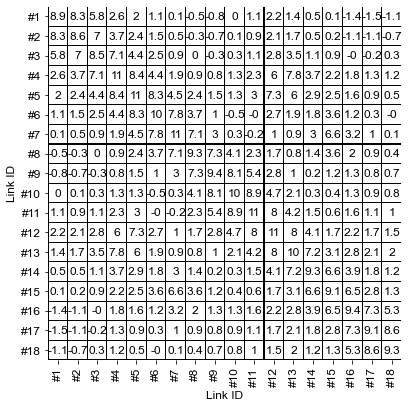

In [408]:
import matplotlib.pyplot as plt
import seaborn as sns

f,ax = plt.subplots(figsize = (6.5, 6.5))
plt.rc('font', family = 'Arial', size = 12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
sns.despine(bottom = False, right = False)
sns.heatmap(np.around(Sigma_store2[10000:, :, :].mean(axis = 0), 1), linewidths = 0.05, linecolor = 'black', annot = True, square = True, cbar = 0,
                 annot_kws = {'size':12, 'color':'black'}, vmin = 0, vmax = 10000, cmap = "Greys",
                xticklabels = x_tick, yticklabels = y_tick)

plt.xlabel('Link ID') 
plt.ylabel('Link ID')

plt.savefig('G:\\Test\\new\\est_cov2.pdf', bbox_inches = 'tight')

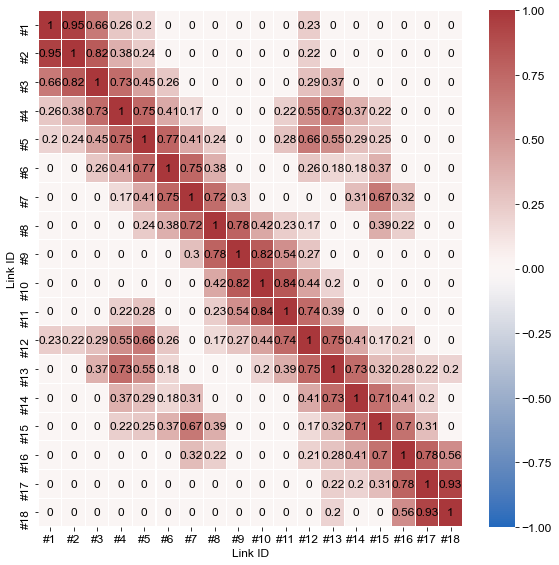

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_plot = Bayesian_Test(Sigma_store2[-5000:, :, :])
plt.subplots(figsize=(9.5, 9.5))
plt.rc('font',family='Arial',size=12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
ax = sns.heatmap(np.around(corr_plot,2),linewidths = 0.005, annot=True,
                 annot_kws={'size':12, 'color':'black'},vmin=-1,vmax=1,cmap="vlag",xticklabels=x_tick, yticklabels=y_tick)
# ax.set_title('True correlation matrix',fontdict= {'fontsize': 25})
ax.tick_params(axis='x',labelsize=12)
plt.xlabel('Link ID') 
plt.ylabel('Link ID')
# plt.savefig(r'C:\Data\Synthesis_Estimation.png')
plt.savefig('G:\\Test\\new\\Estimated_complete_missing.pdf', bbox_inches='tight')

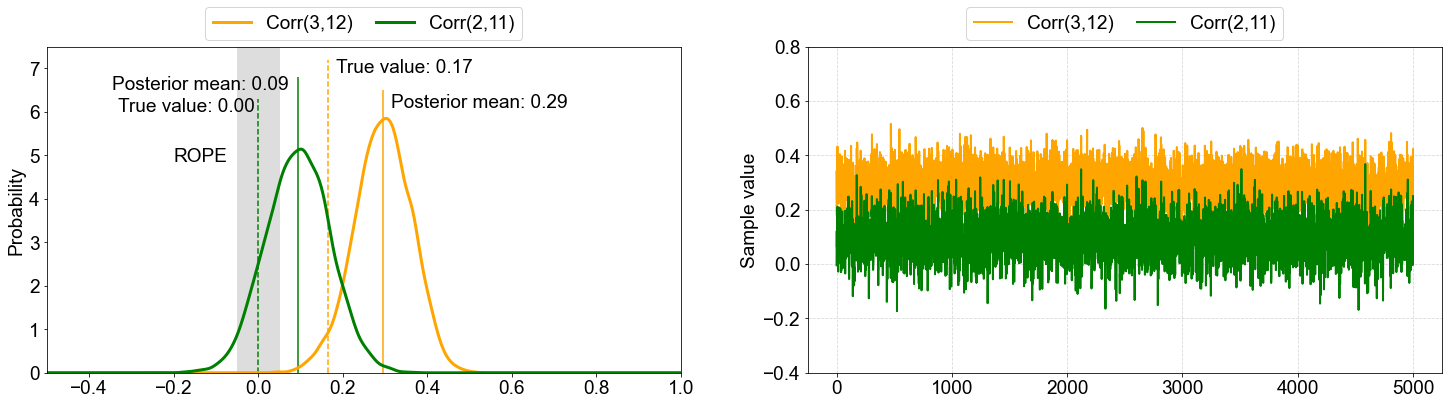

In [420]:
fig, ax = plt.subplots(1, 2, figsize = (25, 6)) # a figure with a 2x2 grid of Axes
x_time = np.arange(0, 5000)
fontset = {'fontsize': 19, 'color': 'black'}
plt.rc('font',family='Arial',size=19)

Sig_1 = Sigma_store2[10000:,:,:]
iteration, d1, d2 = Sig_1.shape
A1_store = np.zeros((iteration, d1, d2))
for it1 in range(iteration):
    A1_store[it1, :, :,] = Corr(Sig_1[it1, :, :])
cd = A1_store
corr_true = Corr(cov)
c11 = 2
c12 = 11
c21 = 1
c22 = 10
data = cd[:, c11, c12]
density = gaussian_kde(data)
xs = np.linspace(-2, 2, 2000)
data2 = cd[:, c21, c22]
density2 = gaussian_kde(data2)

ax[0].plot(xs, density(xs), color = 'orange', linestyle = '-', linewidth = 3, label = 'Corr(3,12)')
ax[0].plot(xs, density2(xs), color = 'green', linestyle = '-', linewidth = 3, label = 'Corr(2,11)')
# ax[0].set_title('cov(4,11)',fontdict = fontset)
ax[0].legend()
# ax[0].set_xlabel('',fontdict = fontset)
ax[0].vlines(data.mean(axis = 0), 0, 6.5, colors = "orange", linestyles = "-")
ax[0].text(data.mean(axis = 0) + 0.02, 6.1, 'Posterior mean: ' + str(np.around(data.mean(axis = 0), 2)))
ax[0].vlines(corr_true[c11, c12], 0, 7.2, colors = "orange", linestyles = "--")
ax[0].text(corr_true[c11, c12] + 0.02, 6.9, 'True value: ' + str(np.around(corr_true[c11, c12], 2)))
ax[0].vlines(data2.mean(axis = 0), 0, 6.8, colors = "green", linestyles = "-")
ax[0].text(data2.mean(axis = 0) - 0.44, 6.5, 'Posterior mean: ' + str(np.around(data2.mean(axis = 0), 2)))
ax[0].vlines(0, 0, 6.3, colors = "green", linestyles = "--")
ax[0].text(- corr_true[c21, c22] - 0.32, 6.0, 'True value: 0.00')
ax[0].fill_between([-0.05, 0.05], [7.5, 7.5], [0, 0], color = "#dddddd")
ax[0].text(- 0.2, 4.85, 'ROPE')
ax[0].set_xlim(-0.5, 1)
ax[0].set_ylim(0, 7.5)
ax[0].set_ylabel('Probability',fontdict = fontset)
ax[0].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

ax[1].plot(x_time, data, color = 'orange', linestyle = '-', linewidth = 2, label = 'Corr(3,12)')
ax[1].plot(x_time, data2, color = 'green', linestyle = '-', linewidth = 2, label = 'Corr(2,11)')
# ax[1].set_title('cov(4,11)',fontdict = fontset)
# ax[1].set_xlabel('',fontdict = fontset)
ax[1].set_ylim(-0.4, 0.8)
ax[1].set_ylabel('Sample value',fontdict = fontset)
ax[1].grid(linestyle = '--', color = '0.85', visible = True)
ax[1].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
fig.savefig('G:\\Test\\new\\markov_sampling2.pdf', bbox_inches='tight')

In [362]:
# Covariance
# initialization

start = time.time()

# gibbs sampling

maxepoch = 15000
mu_store3 = np.zeros((maxepoch, link_num))
Sigma_store3 = np.zeros((maxepoch, link_num, link_num))

# initialize the parameters of priors

flag = 0
beta_0 = 10
v_0 = link_num + 2
W_0 = np.eye(link_num) # 20*20
mu_0 = b1.mean(axis = 0)

X = b1
N = X.shape[0]
X_bar = np.mean(X, axis = 0)
mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
S = (N - 1) * np.cov((X - bar_d).T)
W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)  
Sigma_hyper = W_hyper / (N + v_0 - link_num - 1)

X_1 = b1
X_2 = np.zeros((b2.shape[0],link_num))
X_3 = np.zeros((b3.shape[0],link_num))
X_4 = np.zeros((b4.shape[0],link_num))

for epoch in range(maxepoch):

    # Route 1   incomplete
    for i in range(X_2.shape[0]):
        X_2[i] = imputation(mu_hyper,Sigma_hyper,A2,b2[i])

    # Route 2 
    for i in range(X_3.shape[0]):
        X_3[i] = imputation(mu_hyper,Sigma_hyper,A3,b3[i])

    # Route 3
    for i in range(X_4.shape[0]):
        X_4[i] = imputation(mu_hyper,Sigma_hyper,A4,b4[i])

    X = np.vstack((X_1, X_2, X_3, X_4))
    N = X.shape[0]
    X_bar = np.mean(X, axis = 0)
    mu_hyper = (N * X_bar + beta_0 * mu_0) / (N + beta_0)
    bar_d = np.repeat(X_bar.reshape(1, link_num), repeats = X.shape[0], axis=0)
    S = (N - 1) * np.cov((X - bar_d).T)
    W_hyper = W_0 + S + N * beta_0 / (N + beta_0) * np.outer(X_bar - mu_0, X_bar - mu_0)
    Sigma_hyper = invwishart.rvs(df = N + v_0, scale = W_hyper)
#     mu_hyper = mvnrnd(mu_hyper, Sigma_hyper / (N + beta_0))

    # store the mu and Lambda
    mu_store3[epoch, :] = mu_hyper
    Sigma_store3[epoch, :, :] = Sigma_hyper
    if epoch % 1000 == 0:
        flag += 1
        print(flag)
end = time.time()
print('Running time: %d seconds' % (end - start))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Running time: 585 seconds


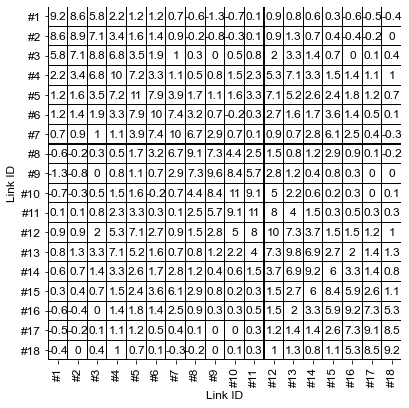

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns

f,ax = plt.subplots(figsize = (6.5, 6.5))
plt.rc('font', family = 'Arial', size = 12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
sns.despine(bottom = False, right = False)
sns.heatmap(np.around(Sigma_store3[10000:, :, :].mean(axis = 0), 1), linewidths = 0.05, linecolor = 'black', annot = True, square = True, cbar = 0,
                 annot_kws = {'size':12, 'color':'black'}, vmin = 0, vmax = 10000, cmap = "Greys",
                xticklabels = x_tick, yticklabels = y_tick)

plt.xlabel('Link ID') 
plt.ylabel('Link ID')

plt.savefig('G:\\Test\\new\\est_cov3.pdf', bbox_inches = 'tight')

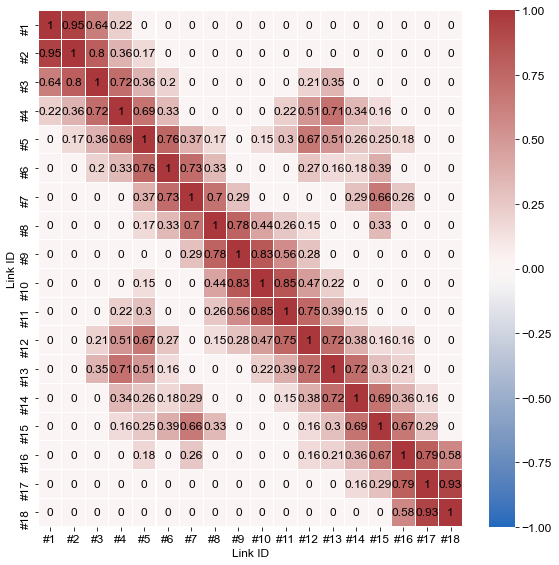

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_plot = Bayesian_Test(Sigma_store3[-5000:, :, :])
plt.subplots(figsize=(9.5, 9.5))
plt.rc('font',family='Arial',size=12)
x_tick=['#' + str(i) for i in range(1,19)]
y_tick=['#' + str(i) for i in range(1,19)]
ax = sns.heatmap(np.around(corr_plot,2),linewidths = 0.005, annot=True,
                 annot_kws={'size':12, 'color':'black'},vmin=-1,vmax=1,cmap="vlag",xticklabels=x_tick, yticklabels=y_tick)
# ax.set_title('True correlation matrix',fontdict= {'fontsize': 25})
ax.tick_params(axis='x',labelsize=12)
plt.xlabel('Link ID') 
plt.ylabel('Link ID')
# plt.savefig(r'C:\Data\Synthesis_Estimation.png')
plt.savefig('G:\\Test\\new\\Estimated_complete_missing_ragged.pdf', bbox_inches='tight')

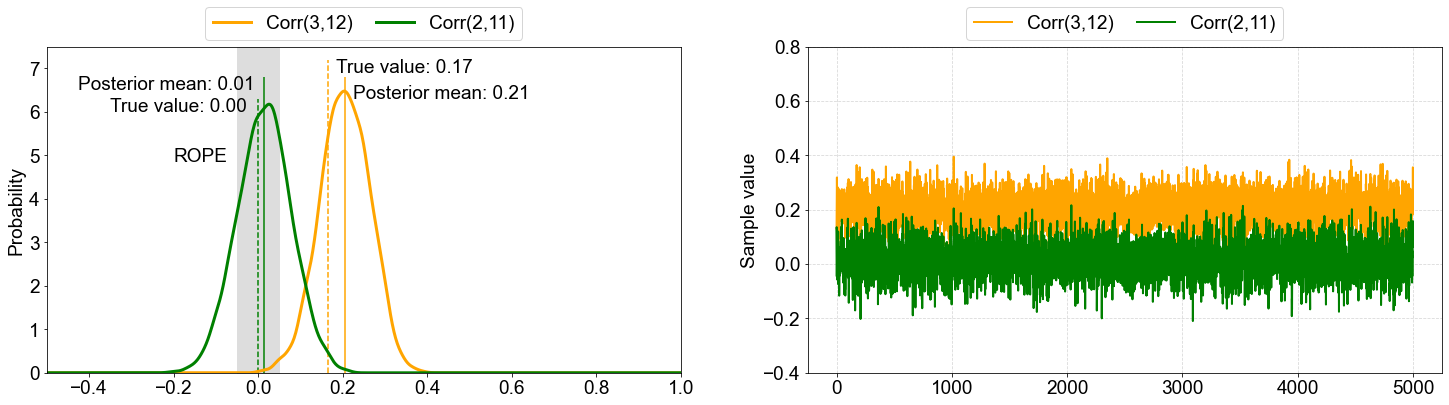

In [423]:
fig, ax = plt.subplots(1, 2, figsize = (25, 6)) # a figure with a 2x2 grid of Axes
x_time = np.arange(0, 5000)
fontset = {'fontsize': 19, 'color': 'black'}
plt.rc('font',family='Arial',size=19)

Sig_1 = Sigma_store3[10000:,:,:]
iteration, d1, d2 = Sig_1.shape
A1_store = np.zeros((iteration, d1, d2))
for it1 in range(iteration):
    A1_store[it1, :, :,] = Corr(Sig_1[it1, :, :])
cd = A1_store
corr_true = Corr(cov)
c11 = 2
c12 = 11
c21 = 1
c22 = 10
data = cd[:, c11, c12]
density = gaussian_kde(data)
xs = np.linspace(-2, 2, 2000)
data2 = cd[:, c21, c22]
density2 = gaussian_kde(data2)

ax[0].plot(xs, density(xs), color = 'orange', linestyle = '-', linewidth = 3, label = 'Corr(3,12)')
ax[0].plot(xs, density2(xs), color = 'green', linestyle = '-', linewidth = 3, label = 'Corr(2,11)')
# ax[0].set_title('cov(4,11)',fontdict = fontset)
ax[0].legend()
# ax[0].set_xlabel('',fontdict = fontset)
ax[0].vlines(data.mean(axis = 0), 0, 6.8, colors = "orange", linestyles = "-")
ax[0].text(data.mean(axis = 0) + 0.02, 6.3, 'Posterior mean: ' + str(np.around(data.mean(axis = 0), 2)))
ax[0].vlines(corr_true[c11, c12], 0, 7.2, colors = "orange", linestyles = "--")
ax[0].text(corr_true[c11, c12] + 0.02, 6.9, 'True value: ' + str(np.around(corr_true[c11, c12], 2)))
ax[0].vlines(data2.mean(axis = 0), 0, 6.8, colors = "green", linestyles = "-")
ax[0].text(data2.mean(axis = 0) - 0.44, 6.5, 'Posterior mean: ' + str(np.around(data2.mean(axis = 0), 2)))
ax[0].vlines(0, 0, 6.3, colors = "green", linestyles = "--")
ax[0].text(- corr_true[c21, c22] - 0.34, 6.0, 'True value: 0.00')
ax[0].fill_between([-0.05, 0.05], [7.5, 7.5], [0, 0], color = "#dddddd")
ax[0].text(- 0.2, 4.85, 'ROPE')
ax[0].set_xlim(-0.5, 1)
ax[0].set_ylim(0, 7.5)
ax[0].set_ylabel('Probability',fontdict = fontset)
ax[0].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

ax[1].plot(x_time, data, color = 'orange', linestyle = '-', linewidth = 2, label = 'Corr(3,12)')
ax[1].plot(x_time, data2, color = 'green', linestyle = '-', linewidth = 2, label = 'Corr(2,11)')
# ax[1].set_title('cov(4,11)',fontdict = fontset)
# ax[1].set_xlabel('',fontdict = fontset)
ax[1].set_ylim(-0.4, 0.8)
ax[1].set_ylabel('Sample value',fontdict = fontset)
ax[1].grid(linestyle = '--', color = '0.85', visible = True)
ax[1].legend(bbox_to_anchor=(0.25,1.02,0.5,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
fig.savefig('G:\\Test\\new\\markov_sampling3.pdf', bbox_inches='tight')

In [411]:
CI(Sigma_store1[10000:,:,:], 1, 10),CI(Sigma_store1[10000:,:,:], 2, 11)

((0.07, 0.46), (0.17, 0.54))

In [412]:
CI(Sigma_store2[10000:,:,:], 1, 10),CI(Sigma_store2[10000:,:,:], 2, 11)

((-0.05, 0.24), (0.16, 0.42))

In [413]:
CI(Sigma_store3[10000:,:,:], 1, 10),CI(Sigma_store3[10000:,:,:], 2, 11)

((-0.11, 0.14), (0.09, 0.31))

In [365]:
 kl_divergence(mean.reshape(-1,1),mu_store1[10000:,].mean(axis=0).reshape(-1,1),cov,Sigma_store1[10000:, :, :].mean(axis = 0))

array([[0.25019066]])

In [366]:
 kl_divergence(mean.reshape(-1,1),mu_store2[10000:,].mean(axis=0).reshape(-1,1),cov,Sigma_store2[10000:, :, :].mean(axis = 0))

array([[0.07483693]])

In [367]:
 kl_divergence(mean.reshape(-1,1),mu_store3[10000:,].mean(axis=0).reshape(-1,1),cov,Sigma_store3[10000:, :, :].mean(axis = 0))

array([[0.05650314]])

In [368]:
mu_store1[10000:,].mean(axis=0),mu_store2[10000:,].mean(axis=0),mu_store3[10000:,].mean(axis=0)

(array([14.06919668, 15.22750071, 18.52230761, 13.67951919, 17.61597435,
        15.26339226,  9.88310996, 23.75734896, 15.22829425, 11.52836655,
        12.42945289, 15.49734687,  9.64352867, 13.3684664 , 17.09599667,
        15.04101232, 19.1377794 , 21.25192048]),
 array([14.18037342, 15.24289586, 18.30919787, 13.25034451, 17.19434266,
        15.18103432, 10.02256937, 24.04488849, 15.10434858, 11.1550278 ,
        12.0671996 , 15.03761009,  9.32146254, 13.34731263, 17.09059905,
        14.78380443, 18.77560236, 20.84865155]),
 array([14.08601827, 15.14294687, 18.23101371, 13.26660356, 17.11479092,
        15.03372042, 10.01815319, 24.08108224, 15.10367622, 11.08532141,
        12.03792155, 15.04084929,  9.23659602, 13.23613722, 17.17022489,
        14.91199988, 18.77405416, 20.78247799]))